<a href="https://colab.research.google.com/github/ArghyaPal/SURE_shot/blob/main/SURE_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essential Library Calls

In [1]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import torch
import torch.fft as fft
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

from __future__ import print_function
from models import skip
import time
import torch.optim
from utils.denoising_utils import *
import copy

### Essential Parameters

In [3]:
width= 328
height= 328
skip_lines = 2
dim = (width, height)

PLOT =  True
sigma = 25
sigma_ = sigma / 255.
INPUT = 'noise'  # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net'  # 'net,input'
OPTIMIZER = 'adam'  # 'LBFGS'

show_every = 100
num_iter = 200
LR = .001
TrainwSURE=True

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
# torch.backends.cudnn.enabled = False
# torch.backends.cudnn.benchmark = False
# dtype = torch.float32

In [ ]:
input_depth = img_np.shape[0]
output_depth = img_np.shape[0]
figsize = 5

### Call and Show Image

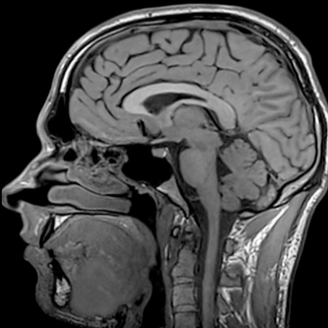

In [4]:
image = cv2.imread("head.png", cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(image)
img_np = pil_to_np(image)
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 6);

if TrainwSURE:
    reg_noise_std = 0
else:
    reg_noise_std =  1. / 30. #Need to jitter input when training only wrt data fidelity term

# Essential Functions for FFT-Shift and Inverse FFT-Shift

### Show FFT Image

Without FFTT-Shift

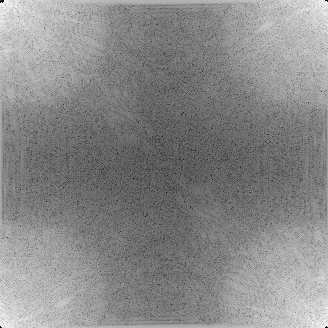

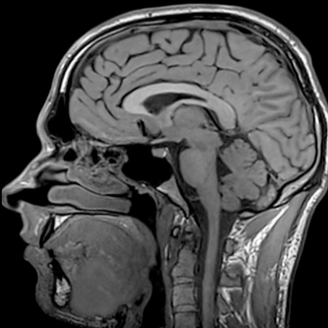

In [8]:
def fft_compute(input):
    f = np.fft.fft2(input)
    #fshit = np.fft.fftshift(f)
    mag = 20*np.log(np.abs(f))
    mag = np.asarray(mag, dtype=np.uint8)
    return mag, input, f

mag, img, f = fft_compute(image)
cv2_imshow(mag)
cv2_imshow(img)

### Reconstruction

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


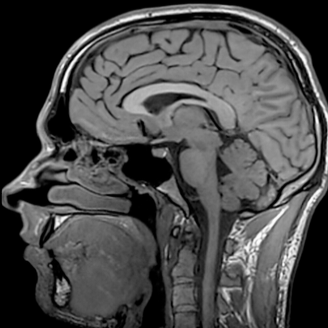

In [10]:
recon = np.fft.ifft2(f)
cv2_imshow(recon)

# K-Space Undersampling

In [11]:
f_undersampled = np.zeros(np.shape(f),dtype=complex)
f_undersampled[0:height:skip_lines, : ] = f[0:height:skip_lines, : ]
#f_undersampled = np.fft.fftshift(f_undersampled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


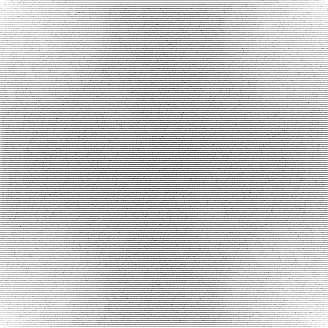

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


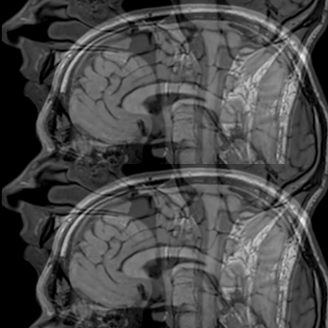

In [12]:
mag_undersampled = 20*np.log(np.abs(f_undersampled))
mag_undersampled = np.asarray(mag_undersampled, dtype=np.uint64)
recon_undersampled = np.fft.ifft2(f_undersampled)

cv2_imshow(mag_undersampled)
cv2_imshow(recon_undersampled)

In [ ]:
net = skip(input_depth, output_depth, num_channels_down=[128, 128, 128, 128, 128, 128, 128, 128],
           num_channels_up=[128, 128, 128, 128, 128, 128, 128, 128],
           num_channels_skip=[15, 13, 11, 9, 7, 5, 3, 1],
           upsample_mode=['nearest', 'nearest', 'nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear', 'bilinear'],
           need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

net = net.type(dtype)
net_input = torch.reshape(torch.from_numpy(img_noisy_np).type(dtype).detach(),
                          (1, input_depth, img_pil.size[1], img_pil.size[0]))

In [ ]:
# Compute number of parameters
s = sum([np.prod(list(p.size())) for p in net.parameters()]);
print('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_var = np_to_torch(img_noisy_np).type(dtype)
img_clean_var = np_to_torch(img_np).type(dtype)

# # Optimize
net_input_saved = net_input.data.clone()
input_noise_vec = net_input.data.clone()

# Variables used to calculate the SURE loss
n = img_np.size

global MSE_losses_wrtinput
global MSE_losses_wrttruth
global SURE_losses
global Divergences_terms
MSE_losses_wrtnoisy = np.zeros(num_iter)
MSE_losses_wrttruth = np.zeros(num_iter)
SURE_losses = np.zeros(num_iter)
Divergences_terms = np.zeros(num_iter)

i = 0

global min_loss
min_loss=np.inf

In [ ]:
def closure():
    global i

    if reg_noise_std > 0:
        net_input.data = net_input_saved + (input_noise_vec.normal_() * reg_noise_std)

    out_0 = net(net_input_saved)
    out = net(net_input)
    out_2 = net(net_input)

    fidelity_loss = mse(out, img_noisy_var)
    true_loss = mse(out, img_clean_var)

    global MSE_losses_wrtnoisy
    global MSE_losses_wrttruth
    MSE_losses_wrtnoisy[i] = fidelity_loss
    MSE_losses_wrttruth[i] = true_loss

    # Calculate the MC divergence and SURE loss before network changes (loss.backward())
    epsilon = 1e-3  # * torch.max(net_input)
    eta = input_noise_vec.normal_()
    net_input_perturbed = net_input.data.clone() + (eta * epsilon)
    out_perturbed = net(net_input_perturbed)
    dx=out_perturbed - out
    eta_dx = torch.sum(eta * dx)  # Inner product between eta and (x_perturbed-x). They must have the same dimensions
    MCdiv = eta_dx / epsilon
    div_term = 2. * sigma_ ** 2 * MCdiv / n


    global SURE_losses
    global Divergences_terms

    SURE_loss = fidelity_loss - sigma_ ** 2 + div_term

    SURE_losses[i] = SURE_loss
    Divergences_terms[i] = div_term

    global min_loss
    global best_net
    if SURE_loss<min_loss:
        min_loss=SURE_loss
        best_net=copy.deepcopy(net)

    print('Iteration %05d    Loss %f' % (i, fidelity_loss.data[0]), '\r', end='')
    if PLOT and i % show_every == 0:
        out_0_np = torch_to_np(out_0)
        plot_image_grid([np.clip(out_0_np, 0, 1)], factor=figsize, nrow=1)
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        out_2_np = torch_to_np(out_2)
        plot_image_grid([np.clip(out_2_np, 0, 1)], factor=figsize, nrow=1)

    i += 1
    if TrainwSURE:
        SURE_loss.backward()
        return SURE_loss
    else:
        fidelity_loss.backward()
        return fidelity_loss
    # true_loss.backward()
    # return true_loss

In [ ]:
start_time = time.time()
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)
end_time=time.time() - start_time


out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

In [ ]:
def EvalError_np(x_hat,x_true):
    x_hat=np.reshape(x_hat,(n,))
    x_true=np.reshape(x_true,(n,))
    mse=np.mean(np.square(x_hat-x_true),axis=0)
    xnorm2=np.mean(np.square( x_true),axis=0)
    mse_thisiter=mse
    nmse_thisiter=mse/xnorm2
    psnr_thisiter=10.*np.log(1./mse)/np.log(10.)
    return mse_thisiter, nmse_thisiter, psnr_thisiter

In [ ]:
in_np=torch_to_np(net_input_saved)
out_np = torch_to_np(net(net_input_saved))
[_,_,PSNR_orig]=EvalError_np(in_np,img_np)
[_,_,PSNR_final]=EvalError_np(out_np,img_np)

out_np = torch_to_np(best_net(net_input_saved))
[_,_,PSNR_final_best]=EvalError_np(out_np,img_np)

print(PSNR_final)
print(PSNR_final_best)

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
if TrainwSURE:
    fig4 = plt.figure()
    l1,=plt.plot(range(num_iter), MSE_losses_wrttruth,'--r',label='NMSE',linewidth=4.0)
    l2,=plt.plot(range(num_iter), SURE_losses, 's-.',label='Training Loss',linewidth=4.0)
    l3, = plt.plot(range(num_iter), Divergences_terms, 'g^', label='Network Divergence', linewidth=4.0)
    plt.legend((l1,l2,l3),('NMSE','Training Loss','Network Divergence'))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.ylim(ymin=-0.005,ymax=0.09)
    plt.show()
    # fig4.savefig('./DeepPrior_TrainedwrtSURE.png')
else:
    fig4 = plt.figure()
    l1,=plt.plot(range(num_iter), MSE_losses_wrttruth,'--r',label='NMSE',linewidth=4.0)
    l2,=plt.plot(range(num_iter), MSE_losses_wrtnoisy, 's-.',label='Training Loss',linewidth=4.0)
    l3, = plt.plot(range(num_iter), Divergences_terms, 'g^', label='Network Divergence', linewidth=4.0)
    plt.legend((l1,l2,l3),('NMSE','Training Loss','Network Divergence'))
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.ylim(ymin=-0.005,ymax=0.09)
    plt.show()
    # fig4.savefig('./DeepPrior_TrainedwrtNoisy.png')